### Initializatoin & definitions

In [5]:
#hide
! pip install -Uqq fastbook duckduckgo_search
import fastbook
fastbook.setup_book()

In [6]:
from fastbook import *
from duckduckgo_search import ddg_images

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


In [7]:
from fastdownload import download_url

def download(name, url):
    dest = name+'.jpg'
    download_url(url, dest, show_progress=False)
def show(name):
    dest = name + '.jpg'
    im = Image.open(dest)
    return im.to_thumb(256,256)

path = Path('glyphs')

### Data collection

In [14]:
maya_glyphs = search_images('maya glyphs')

Searching for 'maya glyphs'


In [15]:
dest = path/'maya'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=maya_glyphs)

In [18]:
petroglyphs = search_images('petroglyphs photo')

Searching for 'petroglyphs photo'


In [19]:
dest = path/'petro'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=petroglyphs)

In [20]:
egypt_glyphs = search_images('egyptian glyphs')

Searching for 'egyptian glyphs'


In [21]:
dest = path/'egypt'
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=egypt_glyphs)

In [22]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#4) [None,None,None,None]

new unseen images

In [23]:
download('petro1', 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Golpayegan.petroglyphs0101.jpg/220px-Golpayegan.petroglyphs0101.jpg')

In [24]:
download('maya-drawing','https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.test.bbc.co.uk%2Fstaticarchive%2Ff5069064298a98a2ff8461118e710bc2c7c40e41.jpg&f=1&nofb=1&ipt=71c8b250985d439a2d19782ec463a44d130f4ce237b045da086781b840a9243b&ipo=images')

In [26]:
download('maya-photo', 'https://www.worldhistory.org/img/r/p/500x600/2307.jpg?v=1659217332')

In [27]:
download('egypt-photo', 'https://media.istockphoto.com/id/98464453/photo/egyptian-hieroglyph.jpg?s=612x612&w=0&k=20&c=CGChMe-xT2UAuQhpIZA1jluQle3sPTcxnGwpqtpRF7c=')

### Training

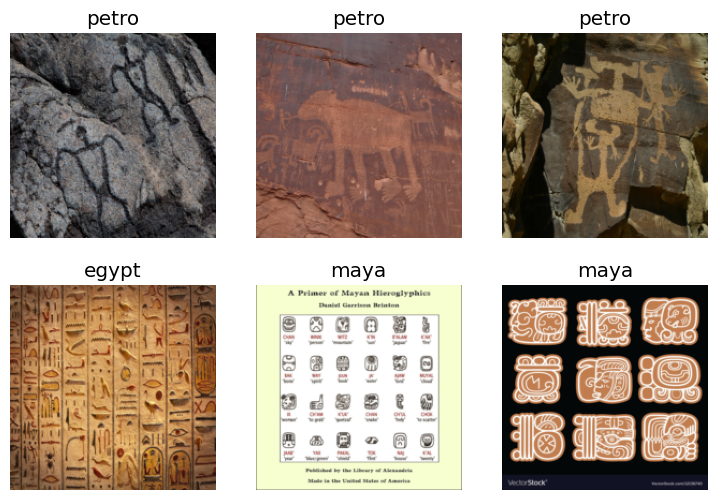

In [28]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [14]:
def classify(learn, test_img):
    is_maya,_,probs = learn.predict(test_img)
    print(test_img)
    print(list(zip(learn.dls.vocab, probs)))

['egypt', 'maya', 'petro']

In [34]:
classify(learn,'maya-photo.jpg')
classify(learn, 'maya-drawing.jpg')


maya-photo.jpg
[('egypt', tensor(0.0007)), ('maya', tensor(0.9983)), ('petro', tensor(0.0010))]


maya-drawing.jpg
[('egypt', tensor(0.0277)), ('maya', tensor(0.9523)), ('petro', tensor(0.0200))]


In [35]:
classify(learn,'petro1.jpg')
classify(learn,'egypt-photo.jpg')

petro1.jpg
[('egypt', tensor(0.0008)), ('maya', tensor(0.0003)), ('petro', tensor(0.9989))]


egypt-photo.jpg
[('egypt', tensor(0.7794)), ('maya', tensor(0.1915)), ('petro', tensor(0.0291))]


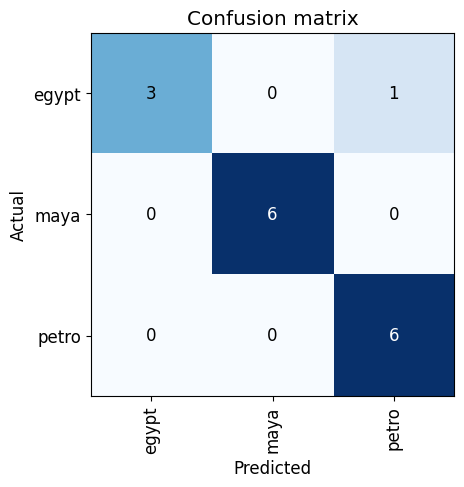

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

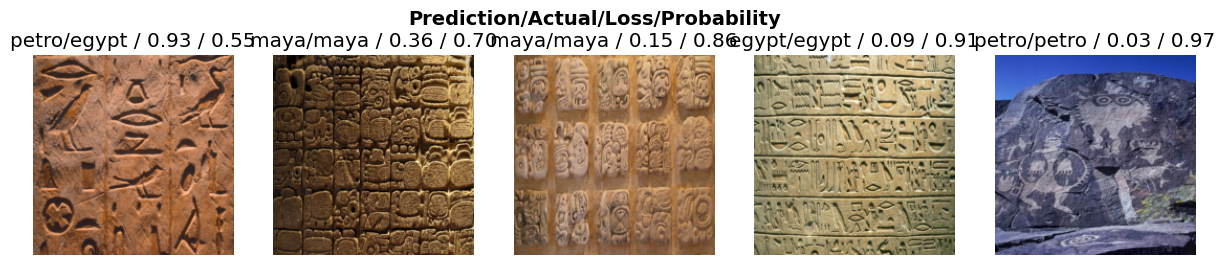

In [37]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

In [67]:
!ls glyphs/maya | wc -l

27


In [66]:
for idx in cleaner.delete(): 
    print('removing')
    cleaner.fns[idx].unlink()

removing


#### Experimenting with data transformations

In [79]:
ResizeMethod()

fastcore.basics.ResizeMethod(Squish='squish', Crop='crop', Pad='pad')

In [80]:
PadMode()

fastcore.basics.PadMode(Zeros='zeros', Border='border', Reflection='reflection')

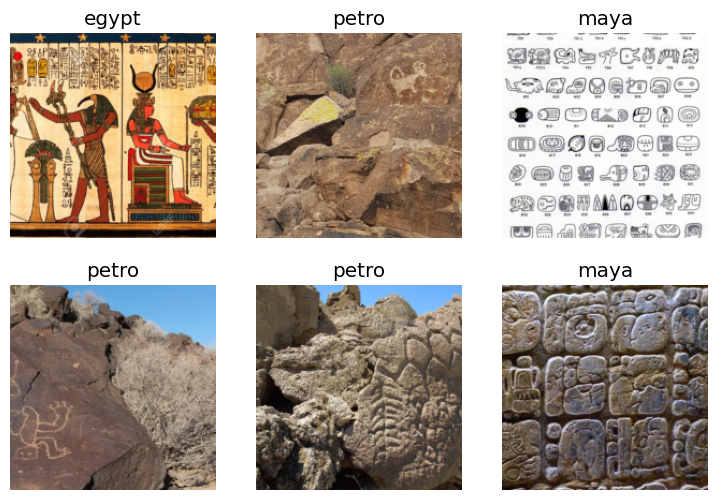

In [39]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='crop')]
    # item_tfms=[Resize(192, method='pad', pad_mode='zeros')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [40]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

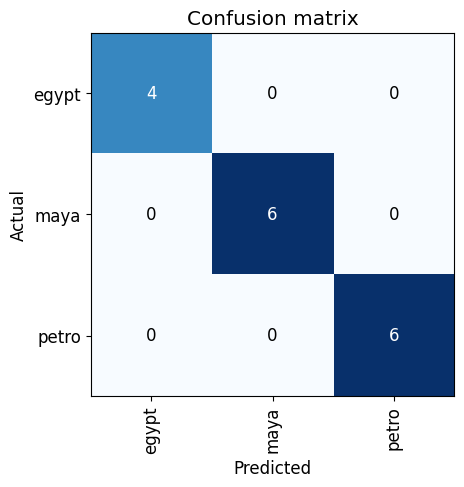

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Export, import and inference

In [42]:
learn.export()

In [8]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [9]:
learn_inf = load_learner(path/'export.pkl')

retrained with crop, the model is much more confident at it's predictions:

In [15]:
classify(learn_inf, 'maya-photo.jpg')
classify(learn_inf, 'maya-drawing.jpg')
classify(learn_inf, 'petro1.jpg')
classify(learn_inf, 'egypt-photo.jpg')

maya-photo.jpg
[('egypt', tensor(0.0009)), ('maya', tensor(0.9985)), ('petro', tensor(0.0006))]


maya-drawing.jpg
[('egypt', tensor(0.0189)), ('maya', tensor(0.9296)), ('petro', tensor(0.0515))]


petro1.jpg
[('egypt', tensor(0.0024)), ('maya', tensor(0.0014)), ('petro', tensor(0.9962))]


egypt-photo.jpg
[('egypt', tensor(0.9545)), ('maya', tensor(0.0447)), ('petro', tensor(0.0008))]


### Embeddings and duplicates 

https://towardsdatascience.com/finding-similar-images-using-deep-learning-and-locality-sensitive-hashing-9528afee02f5


In [10]:
class EmbeddingExtractor():
    embeddings=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook)
        self.embeddings = None
    
    def hook(self, module, input, output): 
        out = output.detach().cpu().numpy()
        # self.embeddings = out
        
        if isinstance(self.embeddings, type(None)):
            self.embeddings = out
        else:
            self.embeddings = np.row_stack((self.embeddings, out))
        
    def remove(self): 
        self.hook.remove()

In [15]:
# let's examine the model architecture
learn_inf.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [16]:
ex = EmbeddingExtractor(learn_inf.model[1][5])

In [34]:
learn_inf.predict('maya-photo.jpg')

('maya', tensor(1), tensor([9.0833e-04, 9.9847e-01, 6.2023e-04]))

In [35]:
maya_embedding = ex.embeddings
maya_embedding.shape, maya_embedding.sum()

((1, 512), 317.79572)

In [36]:
learn_inf.predict('egypt-photo.jpg')

('egypt', tensor(0), tensor([9.5448e-01, 4.4716e-02, 8.0422e-04]))

In [37]:
egypt_embedding = ex.embeddings
egypt_embedding.shape, egypt_embedding.sum()

((1, 512), 401.98346)

In [38]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [45]:
maya_embedding[0].shape

(512,)

In [50]:
cos_sim(maya_embedding[0], egypt_embedding[0])

0.3752027

In [49]:
cos_sim(maya_embedding[0], maya_embedding[0])

1.0

to test duplicate search, let's create a duplicate image by just copying one of the existing files  

In [17]:
!ls glyphs/maya | head -n 1

17726b04-d314-45d8-b8fb-9d675556836b.jpg


In [18]:
# takes a random file from maya folder and  duplicates it with a different name
!cp glyphs/maya/17726b04-d314-45d8-b8fb-9d675556836b.jpg glyphs/maya/duplicate.jpg

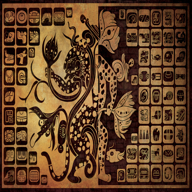

In [19]:
img = Image.open('glyphs/maya/duplicate.jpg')
img.resize((192,192)).show()

In [20]:
dataloader = learn_inf.dls.test_dl(get_image_files(path))

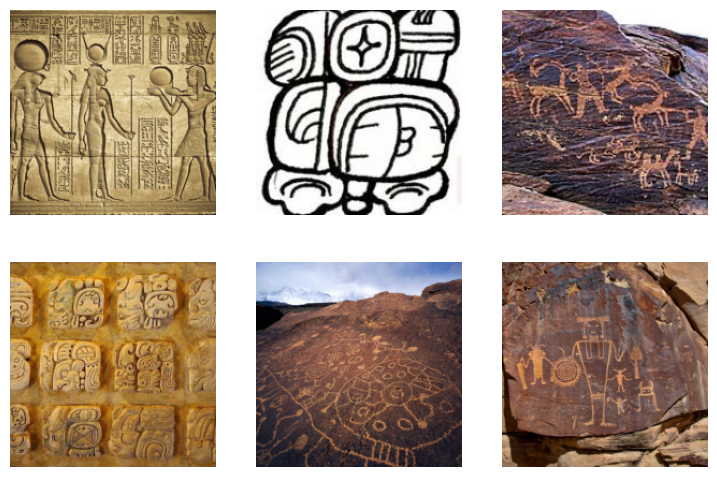

In [21]:
dataloader.show_batch(max_n=6)

In [22]:
len(dataloader.items)

87

In [23]:
_ = learn_inf.get_preds(dl=dataloader)

In [24]:
ex.embeddings.shape

(87, 512)

In [68]:
ex.embeddings

array([[0.        , 0.        , 0.67785263, ..., 0.87656593, 2.382598  , 0.        ],
       [1.4286771 , 1.2593337 , 0.32745838, ..., 0.        , 1.871012  , 0.        ],
       [1.1471685 , 0.        , 0.        , ..., 1.0836656 , 0.4206261 , 3.2071624 ],
       ...,
       [0.7026744 , 0.07981724, 0.11847779, ..., 1.918381  , 2.1936142 , 0.        ],
       [1.5075914 , 0.        , 0.14957482, ..., 2.024578  , 1.5837802 , 0.51221794],
       [1.7513409 , 0.        , 0.        , ..., 1.6080787 , 1.908825  , 0.53367805]], dtype=float32)

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
cos_sim = cosine_similarity(ex.embeddings)


In [46]:
cos_sim.shape

(87, 87)

In [79]:
np.fill_diagonal(cos_sim, 0) # remove self-similarity
cos_sim = np.triu(cos_sim) # remove duplicates

array([0.2589519 , 0.3174169 , 0.37520266, ..., 0.4358946 , 0.5381191 , 0.36764073], dtype=float32)

In [103]:
import pandas as pd
df = pd.DataFrame(cos_sim[cos_sim > 0], columns=['similarity'])
df.describe(include='number')

,similarity
count,3741.000000
mean,0.353920
std,0.106295
min,0.111251
25%,0.280549
50%,0.339447
75%,0.414254
max,1.000000


array([[<AxesSubplot: title={'center': 'similarity'}>]], dtype=object)

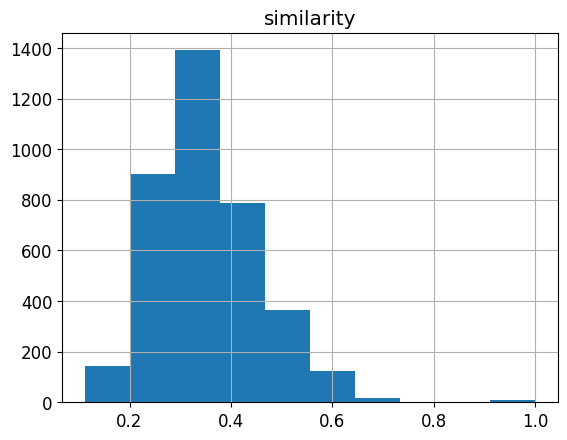

In [104]:
df.hist()

In [109]:
len(cos_sim[cos_sim > 0.9]), len(cos_sim[cos_sim > 0.8]), len(cos_sim[cos_sim > 0.7])

(10, 13, 18)

In [80]:
sorted_flat = np.sort(cos_sim.flatten())
sorted_flat[-10:]


array([0.97809255, 0.98078173, 0.9918164 , 0.9953749 , 0.9953749 , 0.9965074 , 0.9965074 , 0.9997524 , 1.        , 1.0000001 ], dtype=float32)

In [81]:
flat_indices = np.argsort(cos_sim.flatten())

In [55]:
87 * 87

7569

In [82]:
flat_indices.shape

(7569,)

In [83]:
top_10_indices = flat_indices[-10:]

In [84]:
row_indices, col_indices = np.unravel_index(top_10_indices, cos_sim.shape)


In [85]:
row_indices, col_indices

(array([ 3, 73, 42, 41, 48, 35, 35, 33, 40, 41]),
 array([55, 83, 43, 49, 49, 44, 40, 50, 44, 48]))

In [86]:
cos_sim[row_indices, col_indices]

array([0.97809255, 0.98078173, 0.9918164 , 0.9953749 , 0.9953749 , 0.9965074 , 0.9965074 , 0.9997524 , 1.        , 1.0000001 ], dtype=float32)

In [89]:
[(cos_sim[x,y], dataloader.items[x], dataloader.items[y])  for x,y in zip(row_indices, col_indices)]

[(0.97809255,
  Path('maya-photo.jpg'),
  Path('glyphs/maya/7c649e42-6b58-4054-ab08-4effba3da895.jpg')),
 (0.98078173,
  Path('glyphs/egypt/1d386889-ec4f-44c6-b66a-5985e872c792.jpg'),
  Path('glyphs/egypt/cb399ffa-bc66-45f1-90a7-7587ade04ae4.jpg')),
 (0.9918164,
  Path('glyphs/maya/f33d948f-d0d2-44a6-8759-71438fc6ab70.jpg'),
  Path('glyphs/maya/de016ff8-6452-4b9c-b600-8085f9d64d4b.jpg')),
 (0.9953749,
  Path('glyphs/maya/17726b04-d314-45d8-b8fb-9d675556836b.jpg'),
  Path('glyphs/maya/4a2c6e01-d0b2-448f-94ed-71d548cce872.jpg')),
 (0.9953749,
  Path('glyphs/maya/duplicate.jpg'),
  Path('glyphs/maya/4a2c6e01-d0b2-448f-94ed-71d548cce872.jpg')),
 (0.9965074,
  Path('glyphs/maya/4d9346dd-063e-4b45-b56f-d0e440ca7ee1.jpg'),
  Path('glyphs/maya/aedc2028-e19d-4b6a-9157-6676b9e23efb.jpg')),
 (0.9965074,
  Path('glyphs/maya/4d9346dd-063e-4b45-b56f-d0e440ca7ee1.jpg'),
  Path('glyphs/maya/c3c22cc2-62f2-4e94-a0d3-b7723eb6b42f.jpg')),
 (0.9997524,
  Path('glyphs/maya/3dd4c7f2-3acf-476b-94fd-881a68e0bb

In [90]:
(dataloader.items[row_indices[-1:][0]], dataloader.items[col_indices[-1:][0]])

(Path('glyphs/maya/17726b04-d314-45d8-b8fb-9d675556836b.jpg'),
 Path('glyphs/maya/duplicate.jpg'))

So, artificial duplicate has been detected with high similarity:

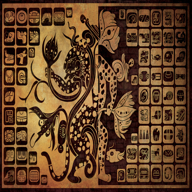

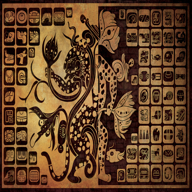

In [91]:
from PIL import Image
img = Image.open(dataloader.items[row_indices[-1:][0]])
img.resize((192,192)).show()

img = Image.open(dataloader.items[col_indices[-1:][0]])
img.resize((192,192)).show()

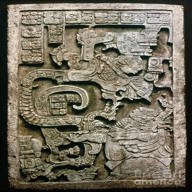

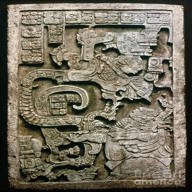

In [92]:
img = Image.open(dataloader.items[row_indices[-2:][0]])
img.resize((192,192)).show()

img = Image.open(dataloader.items[col_indices[-2:][0]])
img.resize((192,192)).show()

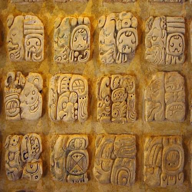

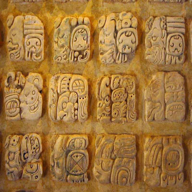

In [94]:
img = Image.open(dataloader.items[row_indices[0]])
img.resize((192,192)).show()

img = Image.open(dataloader.items[col_indices[0]])
img.resize((192,192)).show()

lets display pairs of 10 most similar images

In [ ]:
# displays a picture of the two images that are most similar
img = Image.open(dataloader.items[row_indices[1]])
img.show()

In [ ]:
img = Image.open(dataloader.items[col_indices[1]])
img.show()

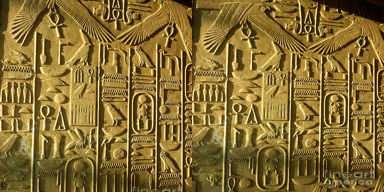

In [111]:
# draws pair of images that are most similar
img = Image.open(dataloader.items[row_indices[1]]).resize((192,192))
img2 = Image.open(dataloader.items[col_indices[1]]).resize((192,192))
img3 = Image.new('RGB', (img.width + img2.width, img.height))
img3.paste(img, (0,0))
img3.paste(img2, (img.width, 0))
img3.show()